In [4]:
%pylab inline

from __future__ import print_function

import os
import random

Populating the interactive namespace from numpy and matplotlib


## Generate

Generowanie zbioru danych na podstawie http://captchas.net/

In [2]:
import src.CaptchasDotNet as CaptchasDotNet

In [3]:
root_path = os.getcwd()

data_dir_path = os.path.join(root_path, 'data', 'dataset2')
img_dir_path = os.path.join(data_dir_path, 'raw')

In [4]:
alphabet = '23456789abcdefghjklmnpqrstuvwxyz'

captchas = CaptchasDotNet.CaptchasDotNet(client='demo', secret='secret', alphabet=alphabet, letters=6)

In [8]:
from IPython.display import Image, display
from IPython.core.display import HTML 

captchas.random()

display(Image(url= captchas.image_url()))
print(captchas.password())

7hng8s


In [32]:
import urllib
from time import sleep
from ipywidgets import IntProgress

samples = 5000

f = IntProgress(min=0, max=samples)
display(f)

for i in range(samples):
    captchas.random()
    
    image_url = captchas.image_url().replace('&amp;', '&')
    label = captchas.password()
    
    img_path = os.path.join(img_dir_path, '{}.png'.format(label))
    
    urllib.urlretrieve(image_url, img_path)
    
    f.value += 1
    
    if i % 10 == 0:
        sleep(1)

In [33]:
print("{} samples in {}".format(len(os.listdir(img_dir_path)), '/'.join(img_dir_path.split('/')[-4:])))

5000 samples in Data-Mining-CAPTCHA-recognizing/data/dataset2/raw


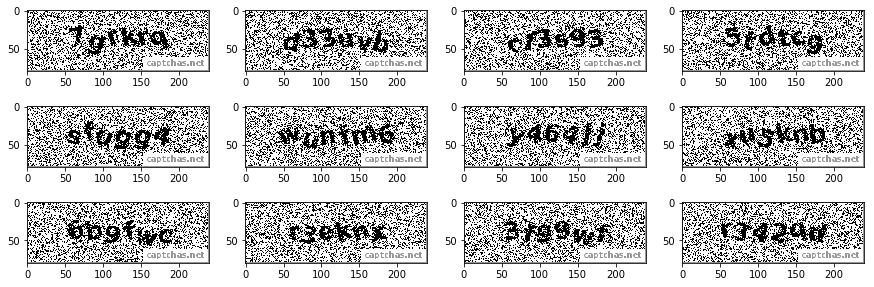

In [34]:
img_filenames = random.sample(os.listdir(img_dir_path), 12)
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(15, 5))

for img_filename, ax in zip(img_filenames, axes.flatten()):
    img_path = os.path.join(img_dir_path, img_filename)
    img = imread(img_path)
    ax.imshow(img)

## Preprocess

W tym miejscu chcemy podzielić surowe CAPTCHA ze znanymi etykietami na poszczególne znaki z również znanymi etykietami. Powstały zbiór wykorzystamy do nauki modelu

### Dataset 1

In [2]:
from src.CAPTCHA_to_signs import DFS

In [3]:
root_path = os.getcwd()

data_dir_path = os.path.join(root_path, 'data', 'dataset1')
img_dir_path = os.path.join(data_dir_path, 'raw')
invalid_img_dir_path = os.path.join(data_dir_path, 'invalid')
train_img_dir_path = os.path.join(data_dir_path, 'train')
test_img_dir_path = os.path.join(data_dir_path, 'test') 

signs_output_dir_path = os.path.join(data_dir_path, 'signs')

Obrazki, które można dobrze podzielić przenosimy do folderu **train**, a pozostałe do **invalid**

In [4]:
for img_filename in os.listdir(img_dir_path):
    img_path = os.path.join(img_dir_path, img_filename)
    
    label = img_filename.split('.')[0].upper()
    signs = DFS(img_path).dfs_all()
    
    # Przenieś niepoprawne obrazki do folderu invalid
    if len(label) != len(signs):
        invalid_img_path = os.path.join(invalid_img_dir_path, img_filename)
        os.rename(img_path, invalid_img_path)
        continue
        
    # Poprawne przenieś do train
    train_img_path = os.path.join(train_img_dir_path, img_filename)
    os.rename(img_path, train_img_path)

OSError: [Errno 2] No such file or directory: '/pio/scratch/2/i279076/Pulpit/ED/project/Data-Mining-CAPTCHA-recognizing/data/dataset1/raw'

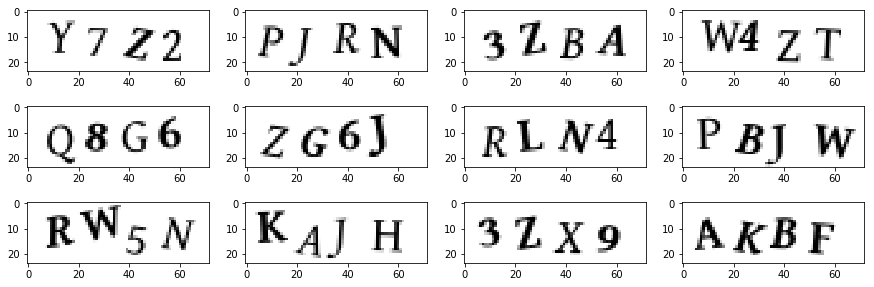

In [14]:
img_filenames = random.sample(os.listdir(train_img_dir_path), 12)
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(15, 5))

for img_filename, ax in zip(img_filenames, axes.flatten()):
    img_path = os.path.join(train_img_dir_path, img_filename)
    img = imread(img_path)
    ax.imshow(img)

Część obrazków z **train** przenosimy do **test**

In [13]:
# Przenieś część do test
for img_filename in random.sample(os.listdir(train_img_dir_path), 1500):
    img_path = os.path.join(train_img_dir_path, img_filename)
    
    test_img_path = os.path.join(test_img_dir_path, img_filename)
    os.rename(img_path, test_img_path)    

Tworzymy foldery dla wszystkich z mozliwych znaków

In [14]:
for sign in '23456789ABCDEFGHJKLMNPQRSTUVWXYZ':
    sign_dir_path = os.path.join(signs_output_dir_path, sign)
    
    if not os.path.exists(sign_dir_path):
        os.makedirs(sign_dir_path)

Z obrazków ze zbioru trenującego wydzielamy znaki i zapisujemy je w odpowiednim katalogu

In [16]:
from collections import Counter

counter = Counter()

for img_filename in os.listdir(train_img_dir_path):
    img_path = os.path.join(train_img_dir_path, img_filename)
    
    label = img_filename.split('.')[0].upper()
    signs = DFS(img_path).dfs_all()
        
    for sign, target in zip(signs, label):
        counter[target] += 1
        
        sign_path = os.path.join(signs_output_dir_path, target, str(counter[target]))
        sign.save(sign_path)

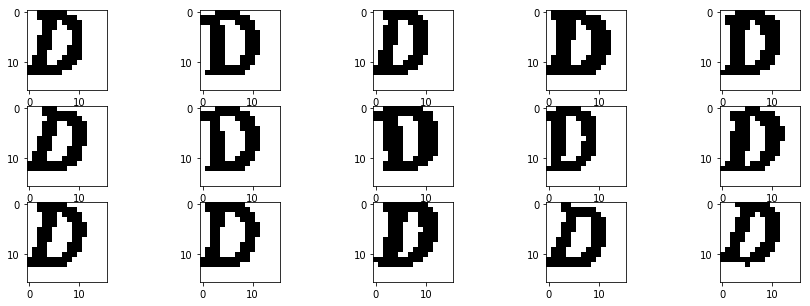

In [20]:
d_sign_dir_path = os.path.join(signs_output_dir_path, 'D')

img_filenames = random.sample(os.listdir(d_sign_dir_path), 15)
fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(15, 5))

for img_filename, ax in zip(img_filenames, axes.flatten()):
    img_path = os.path.join(d_sign_dir_path, img_filename)
    img = imread(img_path)
    ax.imshow(img, cmap='gray')

### Dataset 2

In [6]:
from src.split_by_DBSCAN import DBScan

In [7]:
root_path = os.getcwd()

data_dir_path = os.path.join(root_path, 'data', 'dataset2')
img_dir_path = os.path.join(data_dir_path, 'raw')
invalid_img_dir_path = os.path.join(data_dir_path, 'invalid')
train_img_dir_path = os.path.join(data_dir_path, 'train')
test_img_dir_path = os.path.join(data_dir_path, 'test') 

signs_output_dir_path = os.path.join(data_dir_path, 'signs')

In [7]:
for img_filename in os.listdir(img_dir_path):
    img_path = os.path.join(img_dir_path, img_filename)
    
    label = img_filename.split('.')[0].upper()
    signs = DBScan(img_path, min_samples=8).dbscan()
    
    # Przenieś niepoprawne obrazki do folderu invalid
    if len(label) != len(signs):
        invalid_img_path = os.path.join(invalid_img_dir_path, img_filename)
        os.rename(img_path, invalid_img_path)
        continue
        
    # Poprawne przenieś do train
    train_img_path = os.path.join(train_img_dir_path, img_filename)
    os.rename(img_path, train_img_path)

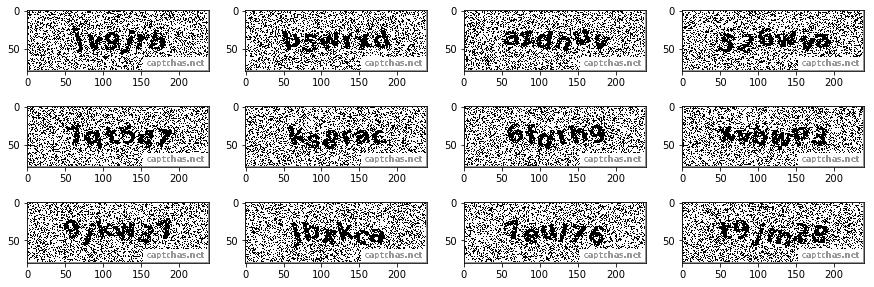

In [8]:
img_filenames = random.sample(os.listdir(train_img_dir_path), 12)
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(15, 5))

for img_filename, ax in zip(img_filenames, axes.flatten()):
    img_path = os.path.join(train_img_dir_path, img_filename)
    img = imread(img_path)
    ax.imshow(img)

In [32]:
# Przenieś część do test
for img_filename in random.sample(os.listdir(train_img_dir_path), 1000):
    img_path = os.path.join(train_img_dir_path, img_filename)
    
    test_img_path = os.path.join(test_img_dir_path, img_filename)
    os.rename(img_path, test_img_path)  

In [10]:
for sign in '23456789ABCDEFGHJKLMNPQRSTUVWXYZ':
    sign_dir_path = os.path.join(signs_output_dir_path, sign)
    
    if not os.path.exists(sign_dir_path):
        os.makedirs(sign_dir_path)

In [11]:
from collections import Counter

counter = Counter()

for img_filename in os.listdir(train_img_dir_path):
    img_path = os.path.join(train_img_dir_path, img_filename)
    
    label = img_filename.split('.')[0].upper()
    signs = DBScan(img_path).dbscan()
        
    for sign, target in zip(signs, label):
        counter[target] += 1
        
        sign_path = os.path.join(signs_output_dir_path, target, str(counter[target]))
        sign.save(sign_path)

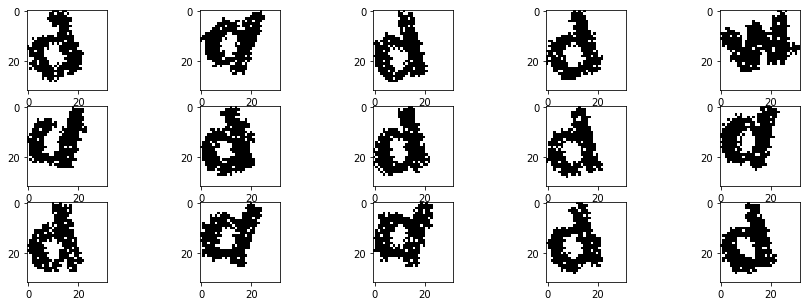

In [11]:
d_sign_dir_path = os.path.join(signs_output_dir_path, 'D')

img_filenames = random.sample(os.listdir(d_sign_dir_path), 15)
fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(15, 5))

for img_filename, ax in zip(img_filenames, axes.flatten()):
    img_path = os.path.join(d_sign_dir_path, img_filename)
    img = imread(img_path)
    ax.imshow(img, cmap='gray')

## Model

Implementacja sieci neuronowej o podstawie dla zbioru MNIST

In [12]:
import keras

from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import CSVLogger, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [13]:
signs_dir_path = os.path.join(data_dir_path, 'signs')

In [76]:
X, y = [], []

for sign in '23456789ABCDEFGHJKLMNPQRSTUVWXYZ':
    sign_dir_path = os.path.join(signs_dir_path, sign)
    
    for img_filename in os.listdir(sign_dir_path):
        img_path = os.path.join(sign_dir_path, img_filename)
        
        img = image.load_img(img_path, grayscale=True)
        img = image.img_to_array(img)
        
        X.append(img)
        y.append(sign)
        
X, y = np.array(X), np.array(y)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [78]:
batch_size = 128
num_classes = len('23456789ABCDEFGHJKLMNPQRSTUVWXYZ')
epochs = 10

In [79]:
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255.
X_test /= 255.

In [80]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (14795, 32, 32, 1)
14795 train samples
3699 test samples


In [81]:
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [82]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

In [83]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [84]:
model_path = os.path.join(root_path, 'model')
log_path = os.path.join(model_path, 'log')

cur_model = 'simple-model-v1-dataset2'
csv_logger = CSVLogger(os.path.join(log_path, cur_model + '.log'))

model_file_name= os.path.join(model_path, cur_model + '-{epoch:03d}-{acc:.5f}.h5')
checkpoint = ModelCheckpoint(model_file_name, verbose=0, save_best_only=True)

In [90]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks=[csv_logger, checkpoint])

Train on 14795 samples, validate on 3699 samples
Epoch 1/10
14795/14795 [==============================] - 1s - loss: 0.1448 - acc: 0.9559 - val_loss: 0.7517 - val_acc: 0.9202
Epoch 2/10
14795/14795 [==============================] - 1s - loss: 0.1363 - acc: 0.9611 - val_loss: 0.7780 - val_acc: 0.9205
Epoch 3/10
14795/14795 [==============================] - 1s - loss: 0.1332 - acc: 0.9613 - val_loss: 0.7356 - val_acc: 0.9189
Epoch 4/10
14795/14795 [==============================] - 1s - loss: 0.1382 - acc: 0.9613 - val_loss: 0.7560 - val_acc: 0.9216
Epoch 5/10
14795/14795 [==============================] - 1s - loss: 0.1335 - acc: 0.9621 - val_loss: 0.6971 - val_acc: 0.9184
Epoch 6/10
14795/14795 [==============================] - 1s - loss: 0.1331 - acc: 0.9606 - val_loss: 0.7415 - val_acc: 0.9186
Epoch 7/10
14795/14795 [==============================] - 1s - loss: 0.1253 - acc: 0.9629 - val_loss: 0.7524 - val_acc: 0.9181
Epoch 8/10
14795/14795 [==============================] - 1s -

In [91]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.788128880061
Test accuracy: 0.919167342751


## Predict

Przetestowanie modelu na danych testowych

In [94]:
correct = 0

for img_filename in os.listdir(test_img_dir_path):
    img_path = os.path.join(test_img_dir_path, img_filename)
    
    label = img_filename.split('.')[0].upper()
    signs = DBScan(img_path).dbscan()
    
    signs = np.array([s.bitmap for s in signs]).reshape(-1, 32, 32, 1)
    predict = model.predict_classes(signs, verbose=0)
    
    if label == ''.join(encoder.classes_[predict]):
        correct += 1

In [95]:
acc = correct * 100. / len(os.listdir(test_img_dir_path))
print("Test CAPTCHA dataset accuracy: {}%".format(acc))

Test CAPTCHA dataset accuracy: 84.7%


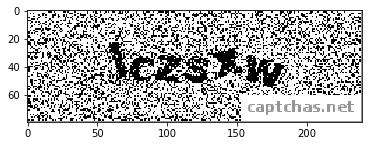

In [96]:
sample_img_filename = random.choice(os.listdir(test_img_dir_path))
sample_img_path = os.path.join(test_img_dir_path, sample_img_filename)

sample_img = imread(sample_img_path)
imshow(sample_img);

L C Z S 7 W


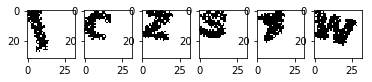

In [98]:
sample_signs = DBScan(sample_img_path).dbscan()

fig, axes = plt.subplots(ncols=len(sample_signs))
for sign, ax in zip(sample_signs, axes):
    ax.imshow(sign.bitmap, cmap='gray')
    
sample_signs_bitmap = np.array([s.bitmap for s in sample_signs]).reshape(-1, 32, 32, 1)
predict = model.predict_classes(sample_signs_bitmap, verbose=0)
print(' '.join(encoder.classes_[predict]))